In [2]:
import pandas as pd
import numpy as np

## Load data

In [3]:
df = pd.read_csv('PastHires.csv')
df

,Years Experience,Employed?,Previous employers,Level of Education,Top-tier school,Interned,Hired
0,10,Y,4,BS,N,N,Y
1,0,N,0,BS,Y,Y,Y
2,7,N,6,BS,N,N,N
3,2,Y,1,MS,Y,N,Y
4,20,N,2,PhD,Y,N,N
5,0,N,0,PhD,Y,Y,Y
6,5,Y,2,MS,N,Y,Y
7,3,N,1,BS,N,Y,Y
8,15,Y,5,BS,N,N,Y
9,0,N,0,BS,N,N,N


In [4]:
df.shape

(13, 7)

In [5]:
df.dtypes

Years Experience       int64
Employed?             object
Previous employers     int64
Level of Education    object
Top-tier school       object
Interned              object
Hired                 object
dtype: object

In [6]:
for col in df.select_dtypes('object').columns:
    df[col] = df[col].astype('category').cat.codes
df

,Years Experience,Employed?,Previous employers,Level of Education,Top-tier school,Interned,Hired
0,10,1,4,0,0,0,1
1,0,0,0,0,1,1,1
2,7,0,6,0,0,0,0
3,2,1,1,1,1,0,1
4,20,0,2,2,1,0,0
5,0,0,0,2,1,1,1
6,5,1,2,1,0,1,1
7,3,0,1,0,0,1,1
8,15,1,5,0,0,0,1
9,0,0,0,0,0,0,0


In [7]:
len(df)

13

In [8]:
df.dtypes

Years Experience      int64
Employed?              int8
Previous employers    int64
Level of Education     int8
Top-tier school        int8
Interned               int8
Hired                  int8
dtype: object

## Using sklearn

In [9]:
from sklearn import tree

In [10]:
X = df.drop('Hired', axis=1)
y = df['Hired']

In [11]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,y)

In [12]:
print(df.loc[2])

clf.predict(X.loc[[2]])

Years Experience      7
Employed?             0
Previous employers    6
Level of Education    0
Top-tier school       0
Interned              0
Hired                 0
Name: 2, dtype: int64


array([0], dtype=int8)

/home/myself/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


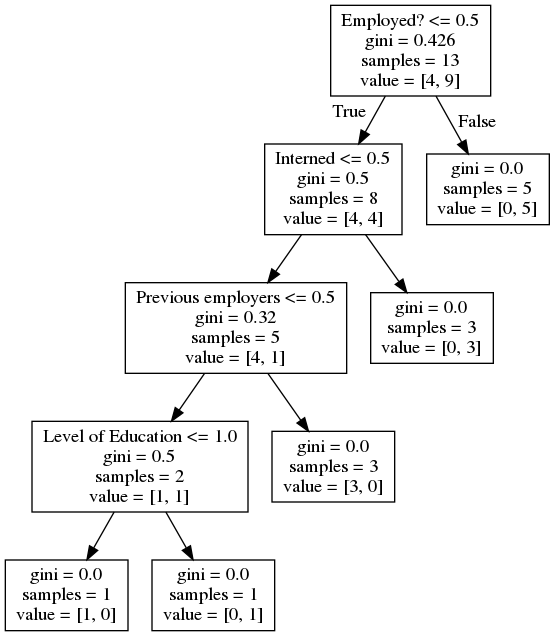

In [13]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=X.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## From scratch

### Gini index

In [14]:
TARGET_NAME = 'Hired'

In [15]:
true_rows  = df[df['Interned'] == 1]
false_rows = df[df['Interned'] == 0]

print(len(true_rows), true_rows[TARGET_NAME].value_counts().to_dict())
print(len(false_rows), false_rows[TARGET_NAME].value_counts().to_dict())
print(len(df))

5 {1: 5}
8 {1: 4, 0: 4}
13


In [16]:
print('gini true_rows:',  1 - (0/5)**2 - (5/5)**2)
print('gini false_rows:', 1 - (4/8)**2 - (4/8)**2)

gini true_rows: 0.0
gini false_rows: 0.5


In [17]:
def gini(X):
    res = 1
    n   = len(X)

    for c, count in X[TARGET_NAME].value_counts().iteritems():
        res -= (count/n)**2

    return res

print('gini true_rows:', gini(true_rows))
print('gini false_rows:', gini(false_rows))

gini true_rows: 0.0
gini false_rows: 0.5


In [18]:
def gini_index(true_rows, false_rows):

    n_true  = len(true_rows)
    n_false = len(false_rows)

    res  = 0
    res += gini(true_rows)  * n_true
    res += gini(false_rows) * n_false

    return res/(n_true+n_false)

gini_index(true_rows, false_rows)

0.3076923076923077

### Find Best Split

In [19]:
def partition(df, b):
    return df[b], df[~b]

In [20]:
true_rows, false_rows = partition(df, df['Interned'] == 1)

print(true_rows[TARGET_NAME].value_counts().to_dict())
print(false_rows[TARGET_NAME].value_counts().to_dict())

{1: 5}
{1: 4, 0: 4}


In [21]:
def find_best_split(rows, verbose=False):
    best_gain = 0
    data = {
        'samples': len(rows),
        'classes': rows[TARGET_NAME].value_counts().to_dict()
    }

    # We reached a leaf
    if len(data['classes']) < 2:
        return 0, data

    # Loop columns except target
    for col in rows.columns:
        if col == TARGET_NAME:
            continue

        values     = rows[col].unique()
        is_numeric = np.issubdtype(rows[col].dtype, np.number)

        # Loop values of column
        for val in values:

            # Partition in two groups (val and !val)
            true_rows, false_rows = partition(
                rows,
                rows[col] <= val if is_numeric
                    else rows[col] == val)

            # Compute information gain
            gain = 1 - gini_index(true_rows, false_rows)

            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            if verbose:
                print('{col:s}:{val:s} {pad:s} {gain:.3f}'.format(
                     col=col,
                     val=str(val),
                     pad=' '*(20-len(col)-len(str(val))),
                     gain=gain
                ))

            # Keep track of the best split
            if gain >= best_gain:
                best_gain = gain

                data['column']     = col
                data['value']      = val
                data['is_numeric'] = is_numeric

    return best_gain, data

gain, data = find_best_split(df, verbose=True)

print('\nBest split:')
pd.Series(data)

Years Experience:10    0.587
Years Experience:0     0.577
Years Experience:7     0.574
Years Experience:2     0.575
Years Experience:5     0.607
Years Experience:3     0.575
Years Experience:15    0.654
Years Experience:1     0.585
Years Experience:4     0.585
Employed?:0            0.692
Previous employers:4   0.587
Previous employers:0   0.577
Previous employers:1   0.585
Previous employers:2   0.574
Previous employers:5   0.654
Level of Education:0   0.575
Level of Education:1   0.607
Top-tier school:0      0.575
Interned:0             0.692

Best split:


samples                 13
classes       {1: 9, 0: 4}
column            Interned
value                    0
is_numeric            True
dtype: object

In [22]:
gain, data = find_best_split(df[df['Interned'] > 0])

print('\nBest split:')
pd.Series(data)


Best split:


samples         5
classes    {1: 5}
dtype: object

### Build tree

In [23]:
def build_tree(rows):
    gain, data = find_best_split(rows)

    if gain == 0:
        return data

    column = data['column']
    value  = data['value']

    true_rows, false_rows = partition(
        rows,
        rows[column] <= value if data['is_numeric']
            else rows[column] == value
    )
    return [
        data,
        build_tree(true_rows),
        build_tree(false_rows)
    ]

tree = build_tree(df)
tree

[{'samples': 13,
  'classes': {1: 9, 0: 4},
  'column': 'Interned',
  'value': 0,
  'is_numeric': True},
 [{'samples': 8,
   'classes': {1: 4, 0: 4},
   'column': 'Employed?',
   'value': 0,
   'is_numeric': True},
  [{'samples': 5,
    'classes': {0: 4, 1: 1},
    'column': 'Previous employers',
    'value': 0,
    'is_numeric': True},
   [{'samples': 2,
     'classes': {1: 1, 0: 1},
     'column': 'Top-tier school',
     'value': 0,
     'is_numeric': True},
    {'samples': 1, 'classes': {0: 1}},
    {'samples': 1, 'classes': {1: 1}}],
   {'samples': 3, 'classes': {0: 3}}],
  {'samples': 3, 'classes': {1: 3}}],
 {'samples': 5, 'classes': {1: 5}}]

### Print tree

In [24]:
classes = sorted(df[TARGET_NAME].unique())
classes

[0, 1]

In [25]:
def print_tree(tree, indent=0):

    if isinstance(tree, list):
        data = tree[0]

        print('{:s}| {:s}:{:s}'.format(
            '-'*indent,
            data['column'],
            str(data['value'])
        ))

        print_tree(tree[1], indent+4)
        print_tree(tree[2], indent+4)

    else:
        count = tree['classes']

        print('{:s}| {:s}'.format(
            '-'*indent,
            str([count.get(c,0) for c in classes])
        ))

print_tree(tree)

| Interned:0
----| Employed?:0
--------| Previous employers:0
------------| Top-tier school:0
----------------| [1, 0]
----------------| [0, 1]
------------| [3, 0]
--------| [0, 3]
----| [0, 5]


### Predict

In [27]:
def predict(tree, x):
    if isinstance(tree, list):
        data = tree[0]

        value = x[data['column']]
        ref   = data['value']

        b     = value <= ref if data['is_numeric'] \
                  else value == ref

        return predict(tree[(1 if b else 2)], x)
    else:
        return max(tree['classes'], key=tree['classes'].get)

predict(tree, {'Interned':1})

1

In [28]:
print(df.loc[2])

predict(tree, df.loc[2])

Years Experience      7
Employed?             0
Previous employers    6
Level of Education    0
Top-tier school       0
Interned              0
Hired                 0
Name: 2, dtype: int64


0